In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len4_ndb_agg_in_oral_DropNever.csv",encoding="shift-jis",index_col=0)

In [3]:
df["year_trend"]=df["year"]-2014
df=df.loc[df["総計"]>0]
df=df.loc[df["revenue"]>0]
df["log_quantity"]=np.log(df["総計"])
df["log_revenue"]=np.log(df["revenue"])
df_generic=df.copy()
df_branded=df.copy()
df_branded=df_branded.loc[df_branded["後発品区分"]==0]
df_generic=df_generic.loc[df_generic["後発品区分"]==1]
df_branded=df_branded.set_index(["id","year"])
df_generic=df_generic.set_index(["id","year"])
df=df.set_index(["id","year"])
df_branded=PanelData(df_branded,convert_dummies=False)
df_generic=PanelData(df_generic,convert_dummies=False)
df=PanelData(df,convert_dummies=False)

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m7         -0.0135     0.1782    -0.0756     0.9397     -0.3632      0.3362
elapsed_m6          0.0368     0.1579     0.2331     0.8157     -0.2729      0.3466
elapsed_m5          0.1192     0.0959     1.2433     0.2140     -0.0689      0.3073
elapsed_m4          0.2273     0.1426     1.5936     0.1113     -0.0525      0.5072
elapsed_m3          0.0518     0.0645     0.8026     0.4224     -0.0748      0.1783
elapsed_m2          0.3009     0.1466     2.0527     0.0403      0.0133      0.5884
elapsed_m1          0.2394     0.1091     2.1939     0.0284      0.0253      0.4535
elapsed_0           0.1711     0.1417     1.2075     0.2275     -0.1069      0.4491
elapsed_1           0.1783     0.1422     1.2535     0.2103     -0.1008     

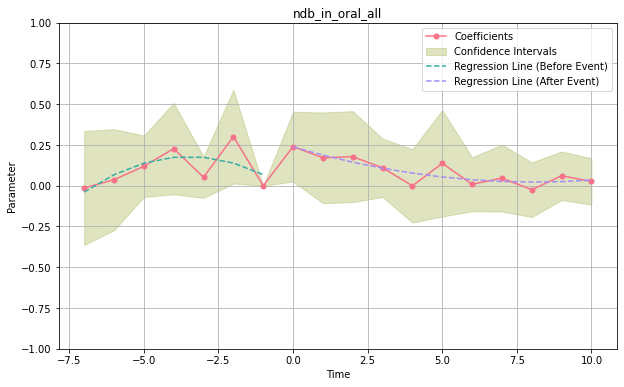

In [4]:
# all data
# period: 15
formula="log_quantity~ elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_m1+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+後発品区分+oral+in_hospital+TimeEffects+EntityEffects"
# period:20
# formula="log_quantity~ elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_m1+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+後発品区分+oral+in_hospital+TimeEffects+EntityEffects"
# year trend
# formula+="+"+"year_trend"
# generic_per
formula+="+"+"generic_per"
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
# print(res_fe)
# plot_result(res_fe, file_name="ndb_in_oral_all",title="ndb_in_oral_all",period=15)
plot_result(res_fe, file_name="ndb_in_oral_all",title="ndb_in_oral_all")

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_quantity   R-squared:                        0.3487
Estimator:                   PanelOLS   R-squared (Between):             -0.1119
No. Observations:                 572   R-squared (Within):              -2.3491
Date:                Mon, Sep 11 2023   R-squared (Overall):             -0.5765
Time:                        02:36:32   Log-likelihood                   -888.94
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.458
Entities:                          31   P-value                           0.0000
Avg Obs:                       18.452   Distribution:                  F(22,512)
Min Obs:                       6.0000                                           
Max Obs:                       32.000   F-statistic (robust):           6.85e+06
                            

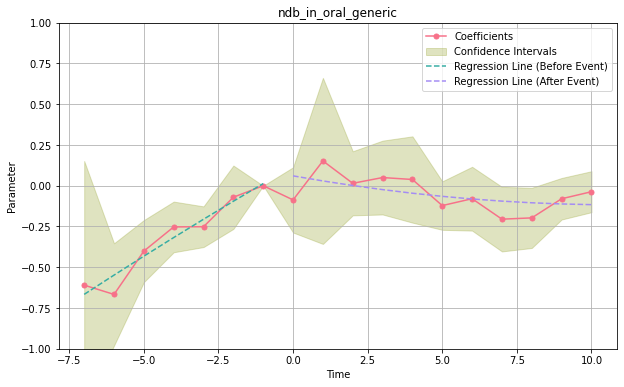

In [5]:
# generic data
formula="log_quantity~elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_m1+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+oral+in_hospital+TimeEffects+EntityEffects"

# period:20
# formula="log_quantity~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_m1+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+oral+in_hospital+TimeEffects+EntityEffects"
# year trend
# formula+="+"+"year_trend"
# generic_per
formula+="+"+"generic_per"
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
mod_fe=PanelOLS.from_formula(formula, data=df_generic,check_rank=False,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
# plot_result(res_fe, file_name="ndb_in_oral_generic",title="ndb_in_oral_generic",period=15)
plot_result(res_fe, file_name="ndb_in_oral_generic",title="ndb_in_oral_generic")

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_quantity   R-squared:                        0.4009
Estimator:                   PanelOLS   R-squared (Between):             -0.2967
No. Observations:                 717   R-squared (Within):              -1.0506
Date:                Mon, Sep 11 2023   R-squared (Overall):             -0.6175
Time:                        02:36:33   Log-likelihood                   -1319.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      19.949
Entities:                          32   P-value                           0.0000
Avg Obs:                       22.406   Distribution:                  F(22,656)
Min Obs:                       16.000                                           
Max Obs:                       32.000   F-statistic (robust):          6.292e+07
                            

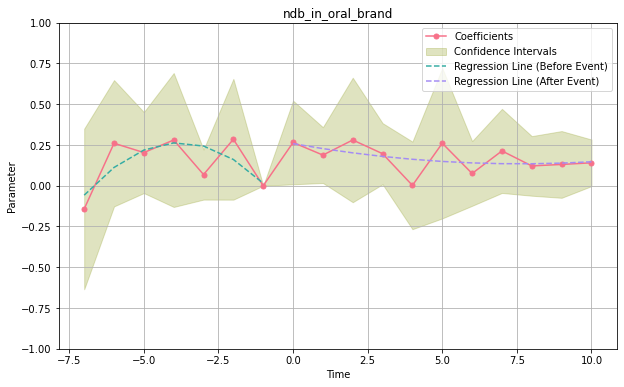

In [6]:
# branded data
formula="log_quantity~ oral+in_hospital+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_m1+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+TimeEffects+EntityEffects"

# period:20
# formula="log_quantity~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_m1+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+oral+in_hospital+TimeEffects+EntityEffects"

# year trend
# formula+="+"+"year_trend"
# generic_per
formula+="+"+"generic_per"
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

mod_fe=PanelOLS.from_formula(formula, data=df_branded,check_rank=False,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
# plot_result(res_fe, file_name="ndb_in_oral_generic",title="ndb_in_oral_generic",period=15)
plot_result(res_fe, file_name="ndb_in_oral_brand",title="ndb_in_oral_brand",start_from=3)